### Prerequisites

Upload the nwpu_labels folder from the repository. It should contain three JSON files (`nwpu_lakes_20samplesA.json`, `nwpu_lakes_20samplesB.json`, `nwpu_lakes_30samples.json`).

#### Setup

In [ ]:
!pip install --default-timeout=1000 tensorflow-gpu==2.0
!pip install rasterio

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from random import shuffle
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import json, os, glob
import zipfile
import rasterio
import requests
import shutil

# GPU OK?
tf.test.is_gpu_available()

True

#### Hyperparameters

In [ ]:
batch_size = 4 # Number of images to pass to each model training epoch
prop_train = 0.5 # Proportion of all images to use for training
num_epochs = 100
img_size = 124

### Datasets

#### Download imagery

In [ ]:
def get_file(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        
        return None
    
    def save_response_content(response, destination):
        CHUNK_SIZE = 32768
        
        with open(destination, 'wb') as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # Filter out keep-alive new chunks
                    f.write(chunk)
    
    URL = 'https://docs.google.com/uc?export=download'
    
    session = requests.Session()
    
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    
    save_response_content(response, destination)

In [ ]:
def unzip(f):
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall()

In [ ]:
# Download imagery
get_file('14kkcuU6wd9UMvjaDrg3PNI-e_voCi8HL', 'NWPU_images.zip')
unzip('NWPU_images.zip')

In [ ]:
# Delete non-lake 
try:
    os.rename('images', 'nwpu_images')
except:
    pass

subdirs = [x[0] for x in os.walk('nwpu_images')][1:]
to_delete = [s for s in subdirs if 'lake' not in s]
for k in to_delete:
    shutil.rmtree(k, ignore_errors = True)
os.rename('nwpu_images' + os.sep + 'lake', 'nwpu_images' + os.sep + 'data')

#### Generate masks from polygons

In [ ]:
# Make directories for NWPU label images
os.mkdir('nwpu_label_images')
os.mkdir('nwpu_label_images' + os.sep + 'data')

In [ ]:
def get_data(data):
    X = []
    Y = []
    for k in data['regions']:
        X.append(data['regions'][k]['shape_attributes']['all_points_x'])
        Y.append(data['regions'][k]['shape_attributes']['all_points_y'])
    return Y, X # Image coords flipped relative to JSON coords

def write_mask(data, images, all_images, i):
    X, Y = get_data(data[images[i]])
    nx, ny, nz = np.shape(all_images[i])
    mask = np.zeros((ny, nx))

    for x, y in zip(X, Y):
        polygon = np.vstack((x, y)).reshape((-1,), order = 'F').tolist()
        
        if nx > ny or ny > nx:
            x, y = y, x
            img = Image.new('L', (ny, nx), 0)
        else:
            img = Image.new('L', (nx , ny), 0)
        
        ImageDraw.Draw(img).polygon(polygon, outline = 1, fill = 1)

        m = np.flipud(np.rot90(np.array(img)))
        try:
            mask = mask + m
        except:
            mask = mask + m.T
    
    matplotlib.image.imsave('nwpu_label_images' + os.sep + 'data' + os.sep + images[i] + '_mask.jpg', mask.astype('uint8'))

#### Load from VGG-JSON

In [ ]:
data = []
json_file = 'nwpu_labels' + os.sep + 'nwpu_lakes_30samples.json'
data.append(json.load(open(json_file)))
json_file = 'nwpu_labels' + os.sep + 'nwpu_lakes_20samplesA.json'
data.append(json.load(open(json_file)))
json_file = 'nwpu_labels' + os.sep + 'nwpu_lakes_20samplesB.json'
data.append(json.load(open(json_file)))

data_merged = {}
for d in data:
    data_merged.update(d)

images = sorted(data_merged.keys())
print(images)
print(len(images))

['lake_001.jpg', 'lake_002.jpg', 'lake_003.jpg', 'lake_004.jpg', 'lake_005.jpg', 'lake_006.jpg', 'lake_007.jpg', 'lake_008.jpg', 'lake_009.jpg', 'lake_010.jpg', 'lake_011.jpg', 'lake_012.jpg', 'lake_013.jpg', 'lake_014.jpg', 'lake_015.jpg', 'lake_016.jpg', 'lake_017.jpg', 'lake_018.jpg', 'lake_019.jpg', 'lake_020.jpg', 'lake_021.jpg', 'lake_022.jpg', 'lake_023.jpg', 'lake_024.jpg', 'lake_025.jpg', 'lake_026.jpg', 'lake_028.jpg', 'lake_029.jpg', 'lake_030.jpg', 'lake_031.jpg', 'lake_032.jpg', 'lake_033.jpg', 'lake_034.jpg', 'lake_035.jpg', 'lake_036.jpg', 'lake_037.jpg', 'lake_038.jpg', 'lake_039.jpg', 'lake_040.jpg', 'lake_041.jpg', 'lake_042.jpg', 'lake_043.jpg', 'lake_044.jpg', 'lake_045.jpg', 'lake_046.jpg', 'lake_047.jpg', 'lake_048.jpg', 'lake_049.jpg', 'lake_050.jpg', 'lake_051.jpg', 'lake_052.jpg', 'lake_053.jpg', 'lake_054.jpg', 'lake_055.jpg', 'lake_056.jpg', 'lake_057.jpg', 'lake_058.jpg', 'lake_059.jpg', 'lake_060.jpg', 'lake_061.jpg', 'lake_642.jpg', 'lake_648.jpg', 'lake_6

In [ ]:
all_images = []
for image in images:
    with rasterio.open('nwpu_images' + os.sep + 'data' + os.sep + image) as dataset:
        all_images.append(dataset.read().T)

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
for i in range(len(images)):
    write_mask(data_merged, images, all_images, i)

#### Dataset generators

In [ ]:
def image_batch_generator(files, batch_size = 32, sz = (512, 512)):
    while True: # loop as many times as the training function calls it
        # Extract a random subset of files of length batch_size
        batch = np.random.choice(files, size=batch_size)

        batch_in = []
        batch_out = []

        # Cycle through each image in the batch
        for f in batch:
        # Preprocess raw images
            rawfile = f'nwpu_images/data/{f}'
            raw = Image.open(rawfile)
            raw = raw.resize(sz)
            raw = np.array(raw)

            # Check the number of channels (some may be RGBA, some may be grayscale)
            if len(raw.shape) == 2:
                raw = np.stack((raw,) * 3, axis = -1)
            else:
                raw = raw[:, :, 0:3]
            
            # Crop the image square based on min(height, width)
            nx, ny, nz = np.shape(raw)
            n = np.minimum(nx, ny)
            raw = raw[:n, :n, :]

            batch_x.append(raw)

            # Get masks
            maskfile = rawfile.replace('nwpu_images', 'nwpu_label_images') + '_mask.jpg'
            mask = Image.open(maskfile)
            mask = np.max(np.array(mask.resize(sz)), axis = 2) # Flatten 3D mask to 2D
            mask = (mask > 100).astype('int') # Water pixels are always > 100

            mask = mask[:n, :n]

            batch_y.append(mask)
        
        # Preprocess batch
        batch_x = np.array(batch_x) / 255 # Normalize to [0, 1]
        batch_y = np.array(batch_y)
        batch_y = np.expand_dims(batch_y, 3) # Add singleton dimension

        yield (batch_x, batch_y) # Yield images and labels together

#### Split

In [ ]:
split = int(prop_train * len(images))
train_files = images[:split]
test_files = images[split:]

train_generator = image_batch_generator(train_files, batch_size = batch_size)
test_generator = image_batch_generator(test_files, batch_size = batch_size)

#### Augmentation

In [ ]:
seed = 42

img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    shear_range=0,
    zoom_range=0,
    rotation_range=90,
    horizontal_flip=True)

img_generator = img_datagen.flow_from_directory(
    'nwpu_images',
    target_size=(128, 128),
    batch_size = 1,
    class_mode = None,
    seed = seed,
    shuffle = False)

mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    shear_range=0,
    zoom_range=0,
    rotation_range=90,
    horizontal_flip=True)

mask_generator = mask_datagen.flow_from_directory(
    'nwpu_label_images',
    target_size = (128, 128),
    batch_size = 1,
    class_mode = None,
    seed = seed,
    shuffle = False)

train_generator = (pair for pair in zip(img_generator, mask_generator))

Found 700 images belonging to 1 classes.
Found 70 images belonging to 1 classes.


### Test

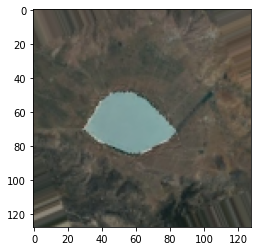

In [ ]:
x, y = next(train_generator)

%matplotlib inline
plt.imshow((x[0]).astype('uint8'), cmap = 'gray')
plt.imshow(np.max(y[0], axis = 2) / 255, cmap = 'gray', alpha = 0.5)

In [ ]:
n_aug_files = 500

# Merge the two generators together, scaling each image to [0, 1]
train_generator2 = (tuple(np.array(pair, dtype = 'float64') / 255) for pair in zip(img_generator, mask_generator))

for i in range(0, n_aug_files):
    x, y = next(train_generator2)
    matplotlib.image.imsave('nwpu_label_images' + os.sep + 'data' + os.sep + 'augimage00' + str(i) + '.jpg_mask.jpg', np.squeeze(y[0]))
    matplotlib.image.imsave('nwpu_images' + os.sep + 'data' + os.sep + 'augimage00' + str(i) + '.jpg', np.squeeze(x[0]))